## Imports

In [2]:
%config InlineBackend.figure_format = 'retina'

import warnings
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from cycler import cycler
from statsmodels.api import tsa
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import colorConverter, Colormap

warnings.filterwarnings('ignore')

np.random.seed(222)
pd.set_option('display.max_columns', None)
plt.rcdefaults()
plt.rcParams['font.family'] = 'serif'
plt.style.use('seaborn-paper')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'brown', 'lime', 'c', 'purple', 'orange', 'navy', 'grey'] * 4) +
                           cycler('linestyle', ['-', '--', '-.', ':'] * 8) + 
                           cycler('marker', list(matplotlib.markers.MarkerStyle.markers.keys())[:32]) + 
                           cycler('linewidth', [1, 1, 2, 2, 1, 2, 1] * 4 + [1, 1, 2, 2])))

## Data Loading and Summaries

In [3]:
# I've changed and saved data as the new version. Rescaled and in the right types now.
data = pd.read_csv('./data/Dataset_1992-2011.csv')

In [4]:
del data['RailToChongqing']
del data['RailToTibet']
data = data[data['Province']!='Chongqing']
data = data[data['Province']!='Tibet']

## Unit-root Test

Note: for KPSS tests, the null hypothesis is **the series is level or trend stationary**! So rejection means non-stationary.

In [6]:
def stationary(g, alpha=.05, verbose=False):
    pvalues = np.array([tsa.kpss(s[1], 'ct')[1] for s in list(g)])
    if verbose: print(pvalues.round(3))
    n_rej = np.less_equal(pvalues, alpha).sum()
    print('{} out of {} series is not trend-stationary'.format(n_rej, len(pvalues)))

## Plots and Test Results

***Population***

In [7]:
year = range(1992, 2012)

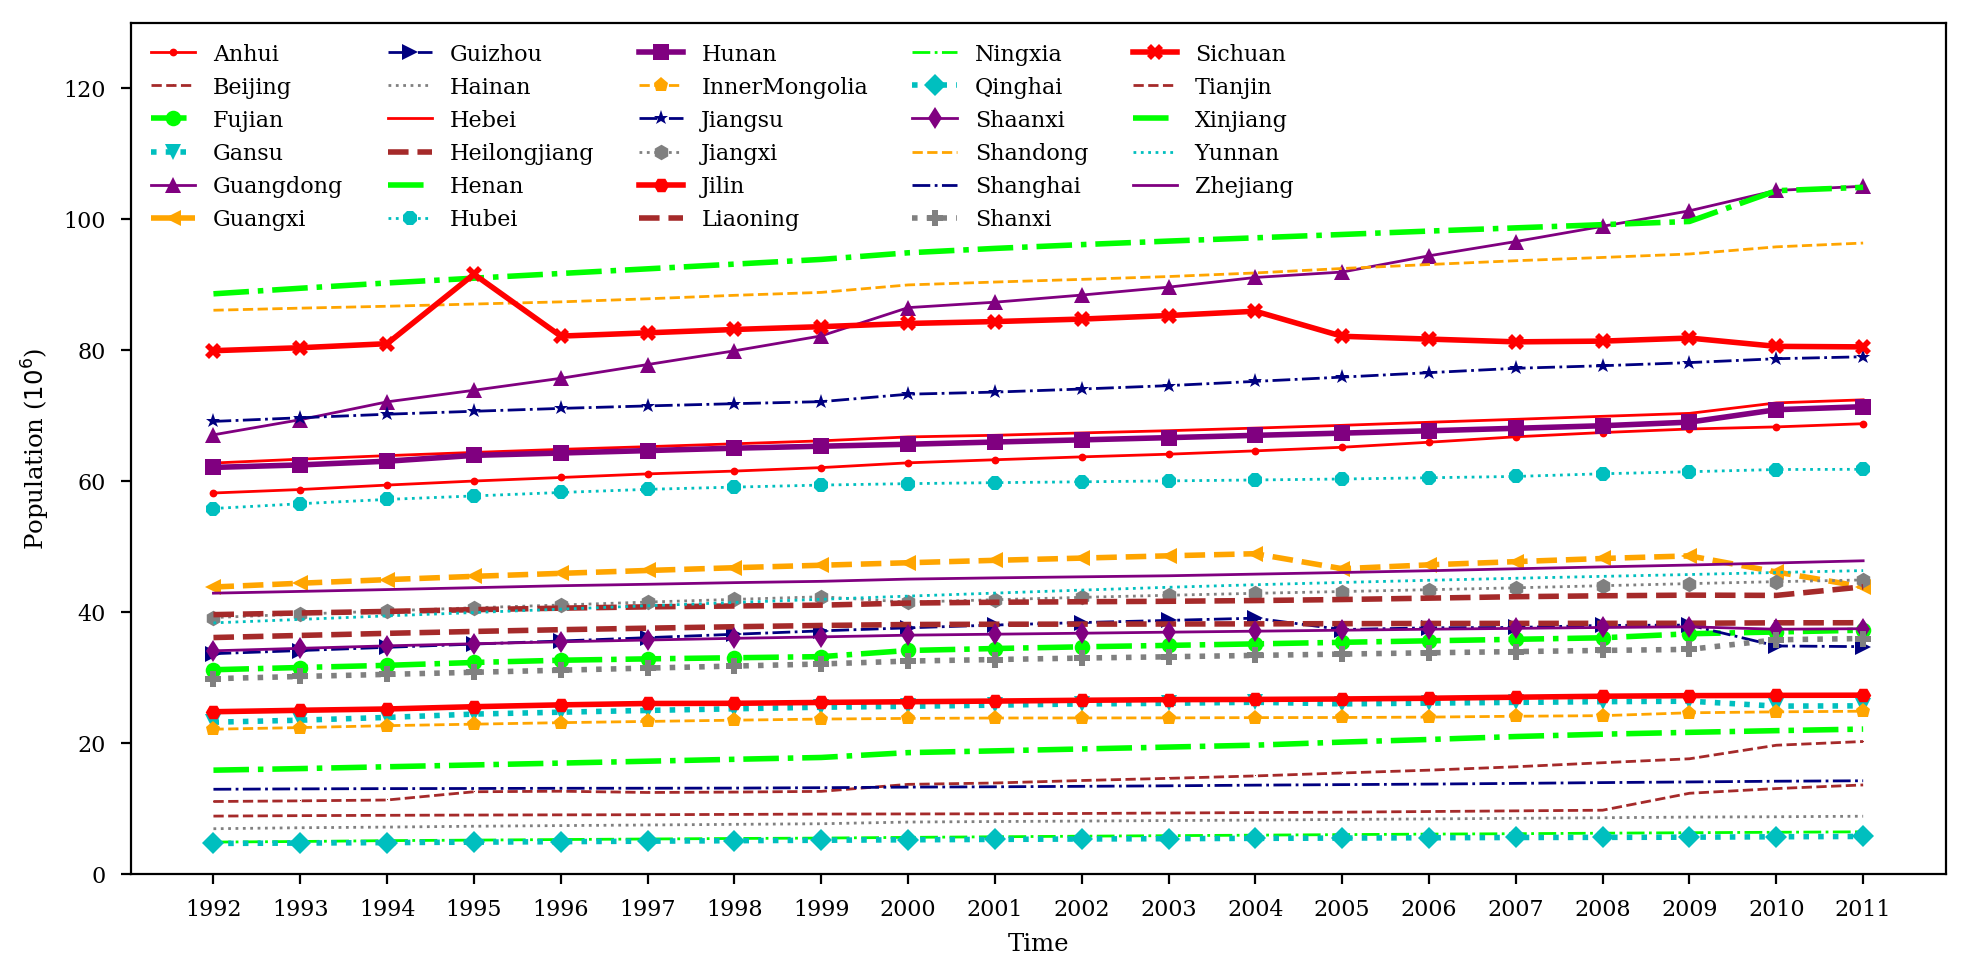

In [8]:
pop = data.Pop.groupby(data.Province)

fig = plt.figure()

ax = fig.add_subplot(111)
for province, p in pop:
    ax.plot(year, p, label=province)
ax.set_xticks(year)
ax.legend(loc='upper left', frameon=False, ncol=5)
ax.set_ylim(0,130)
ax.set_ylabel(r'Population ($10^6$)')
ax.set_xlabel('Time')

plt.tight_layout()
plt.savefig('plots/pop.pdf')
plt.show()

In [10]:
stationary(pop)

29 out of 29 series is not trend-stationary


***Unemployment rate***

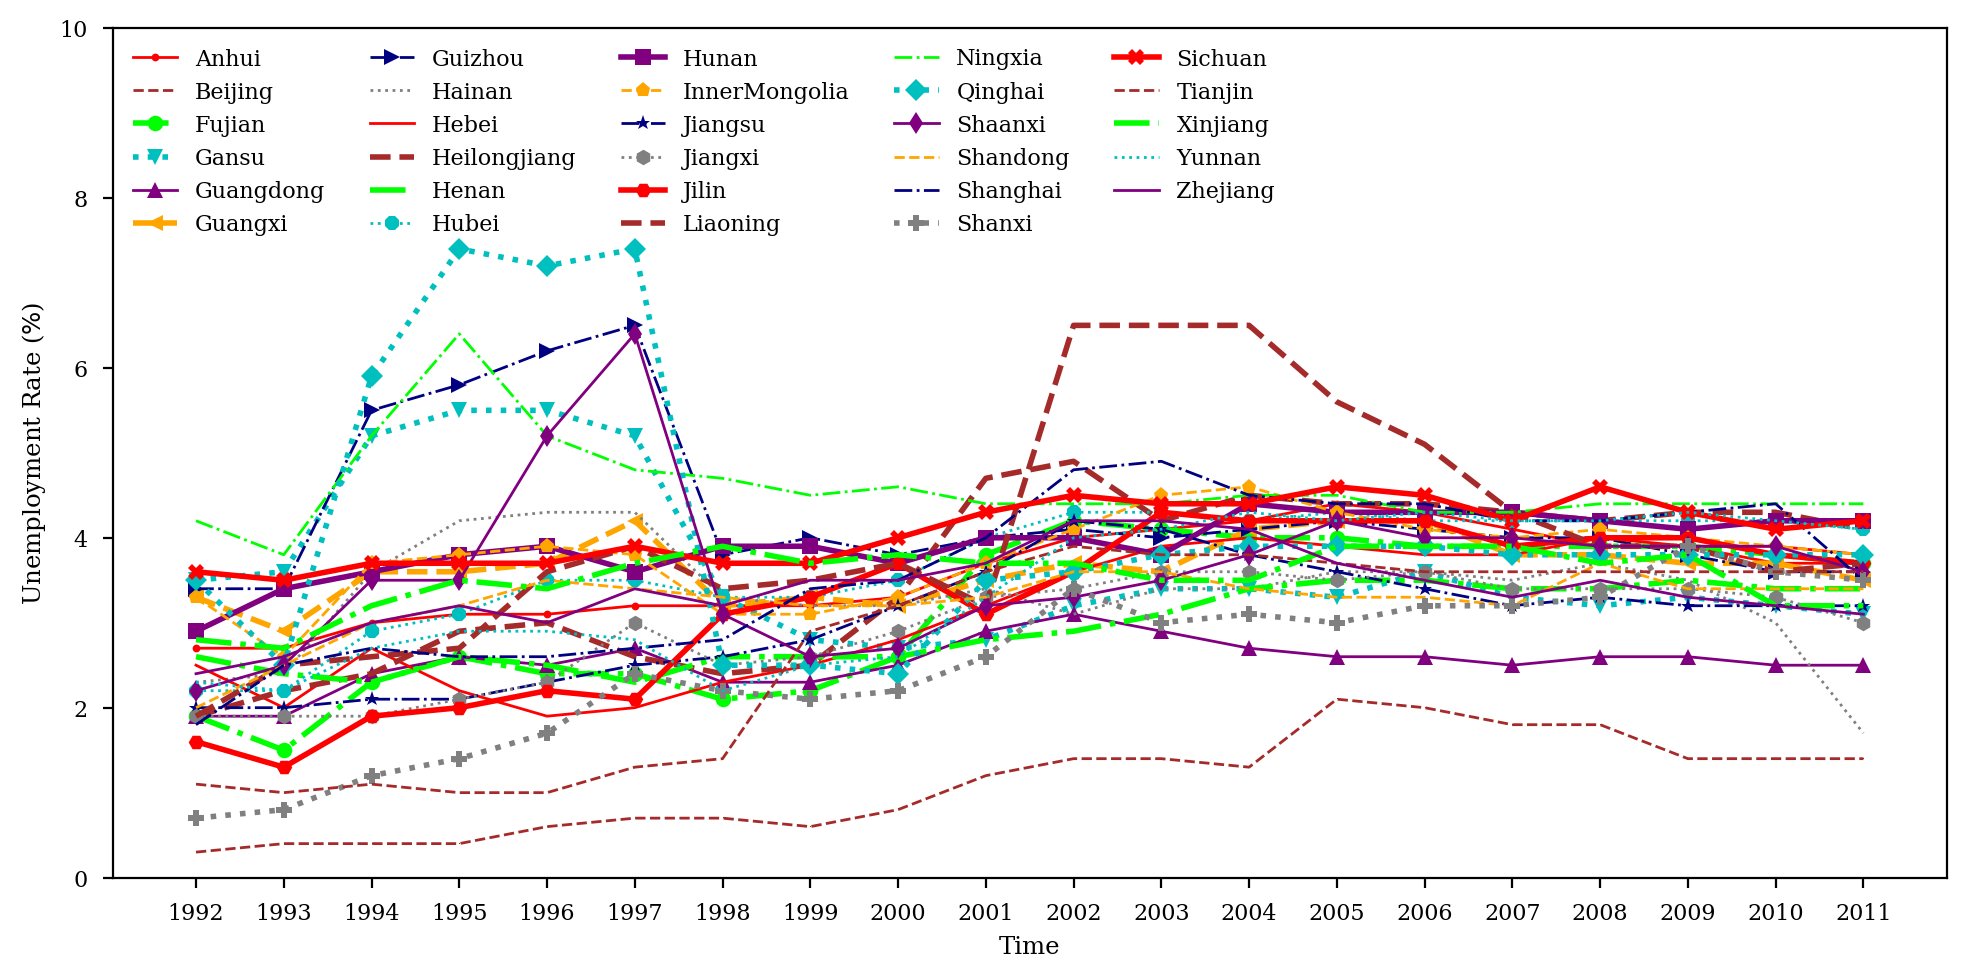

In [27]:
unemprate = data.UnempRate.groupby(data.Province)

fig = plt.figure()

ax = fig.add_subplot(111)
for province, r in unemprate:
    ax.plot(year, r, label=province)
ax.set_xticks(year)
ax.legend(loc='upper left', frameon=False, ncol=5)
ax.set_ylim(0,10)
ax.set_ylabel(r'Unemployment Rate ($\%$)')
ax.set_xlabel('Time')

plt.tight_layout()
plt.savefig('plots/unemp.pdf')
plt.show()

In [28]:
stationary(unemprate)

29 out of 29 series is not trend-stationary


In [29]:
temp = pd.DataFrame({pp:p.values for pp,p in list(unemprate)}, index=year)
temp.to_csv('data/unemp.csv')
temp.unstack().to_csv('data/unemp_long.csv')

***Nominal GDP***

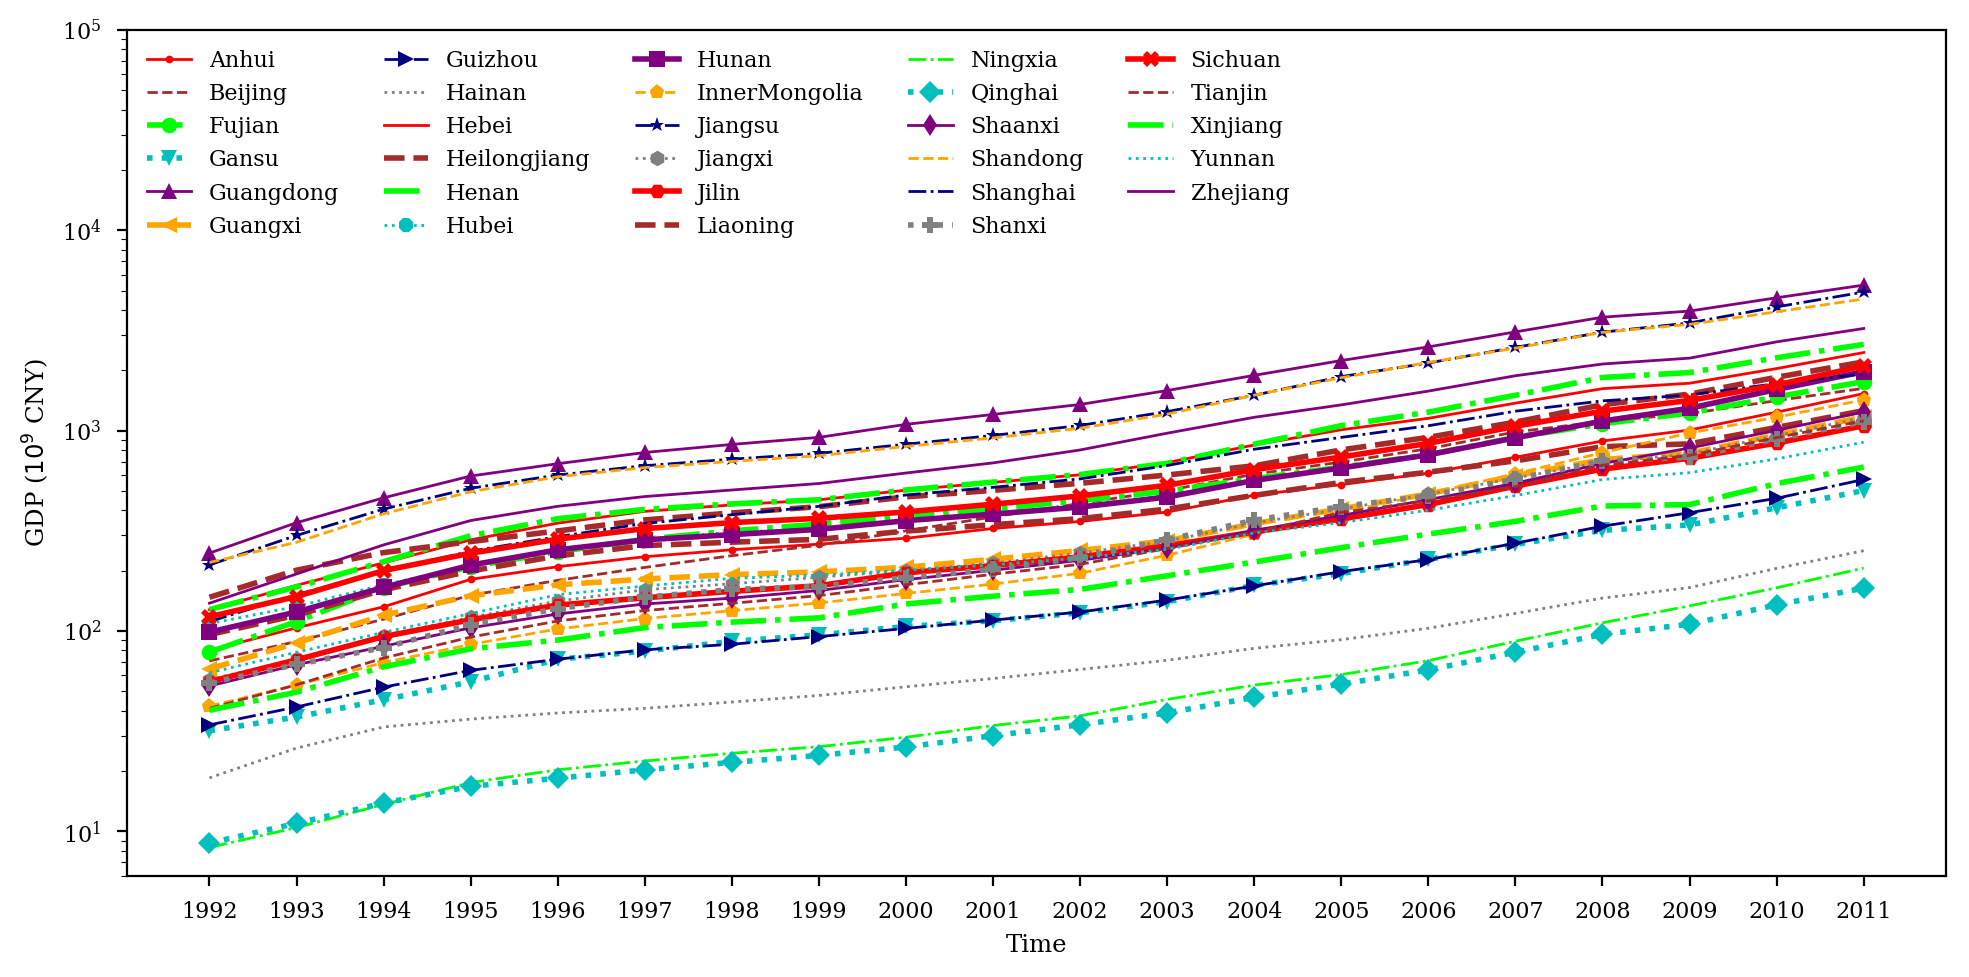

In [20]:
gdp = data.GDP.groupby(data.Province)

fig = plt.figure()

ax = fig.add_subplot(111)
for province, g in gdp:
    ax.plot(year, g, label=province)
ax.set_xticks(year)
ax.legend(loc='upper left', frameon=False, ncol=5)
ax.set_yscale('log')
ax.set_ybound(upper=1e5)
ax.set_ylabel(r'GDP ($10^9$ CNY)')
ax.set_xlabel('Time')

plt.tight_layout()
plt.savefig('plots/gdp_nom.pdf')
plt.show()

In [21]:
stationary(gdp)

29 out of 29 series is not trend-stationary


***Inflation = CPI - 100***

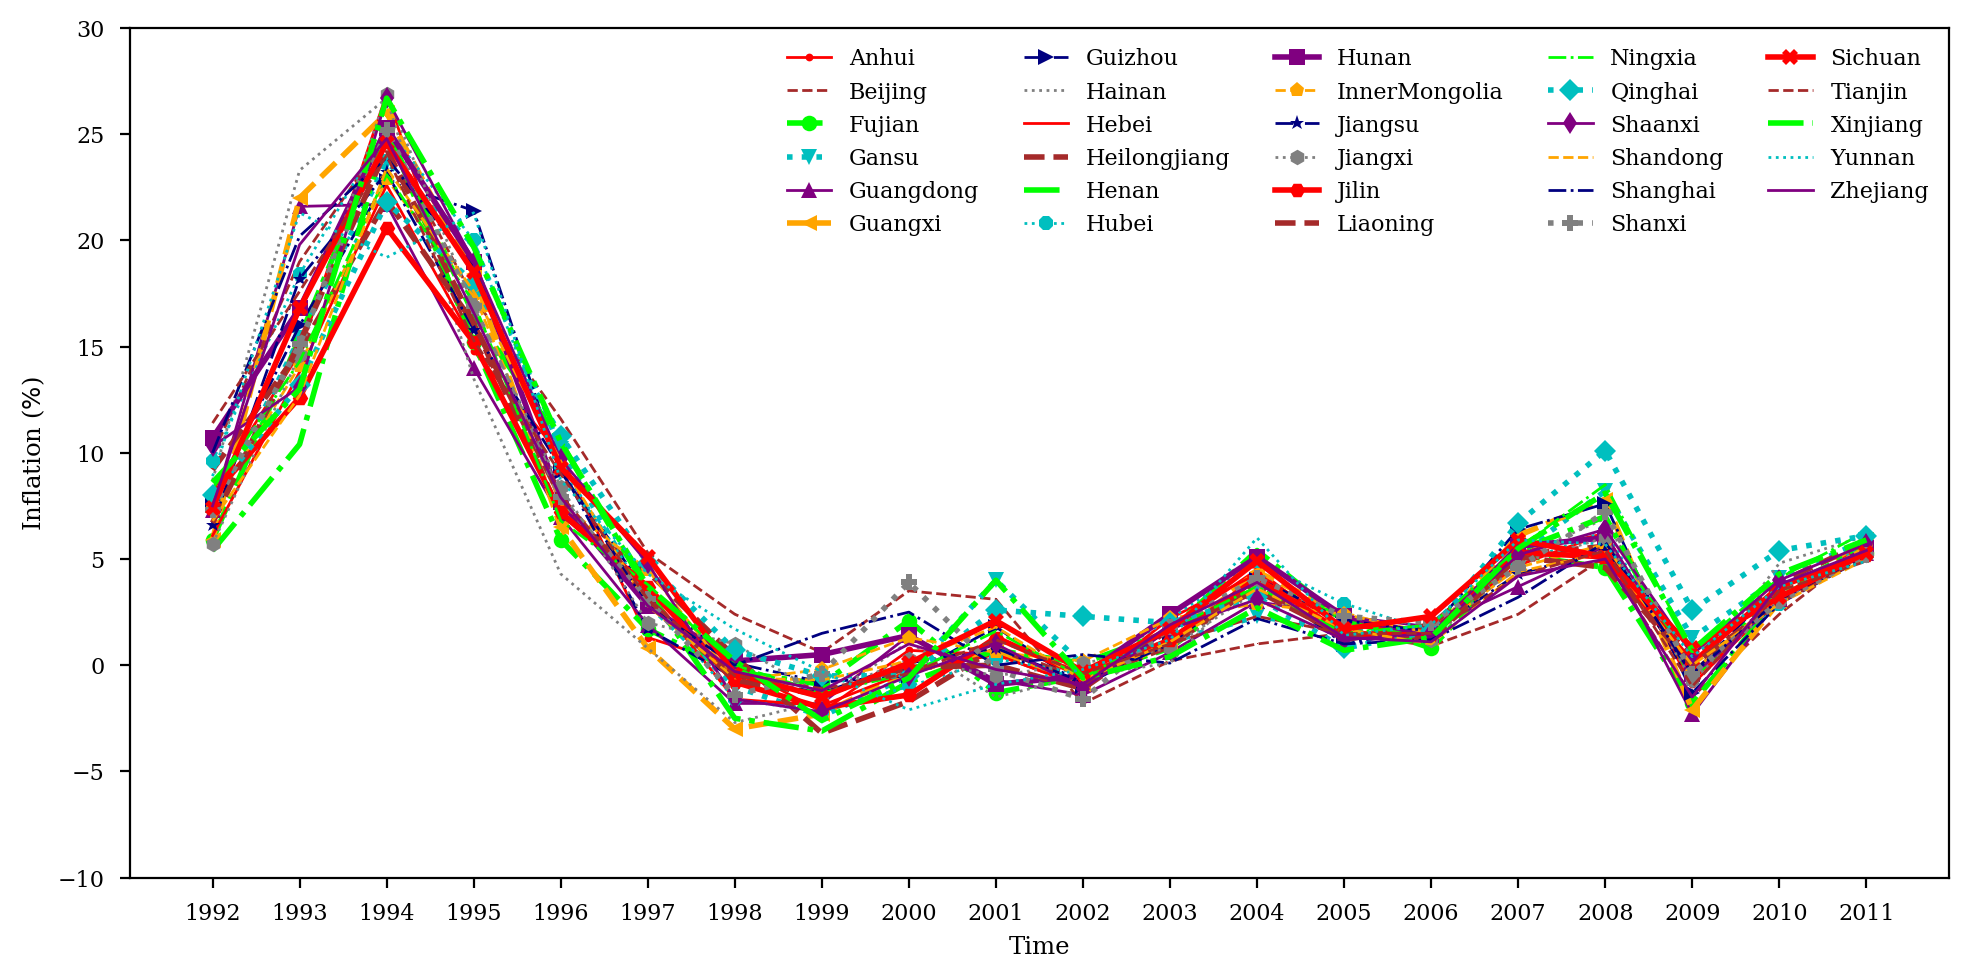

In [22]:
cpi = data.CPI.groupby(data.Province)

fig = plt.figure()

ax = fig.add_subplot(111)
for province, c in cpi:
    ax.plot(year, c-100, label=province)
ax.set_xticks(year)
ax.legend(loc='upper right', frameon=False, ncol=5)
ax.set_ylabel(r'Inflation ($\%$)')
ax.set_ylim(-10, 30)
ax.set_xlabel('Time')

plt.tight_layout()
plt.savefig('plots/inf.pdf')
plt.show()

In [23]:
stationary((data.CPI-100).fillna(0).groupby(data.Province))

29 out of 29 series is not trend-stationary


In [30]:
inf = pd.DataFrame({pp:p.values for pp,p in list((data.CPI-100).fillna(0).groupby(data.Province))}, index=year)
inf.to_csv('data/inf.csv')
inf.unstack().to_csv('data/inf_long.csv')

***Expected Inflation (simple linear regression with backward window length = N)***

In [31]:
from scipy.stats import linregress

In [32]:
N = 2
inf_e = {}
for i in inf:
    inf_e[i] = list(inf[i][:N])
    for y in range(N, 20):
        slope = linregress(np.arange(N), inf[i][y-N:y])[0]
        inf_e[i].append(inf[i].values[y-1] + 2 * slope)
    inf_e[i] = np.array(inf_e[i]).round(2)

In [33]:
inf_e['Beijing']

array([  9.9,  19. ,  37.2,  36.7,   2.1,   0.2,  -7.3,  -3.4,  -3. ,
         9.3,   2.3, -11.6,   4.2,   2.6,   2.5,  -0.3,   5.4,  10.5,
       -14.7,  10.2])

In [34]:
inf_e = pd.DataFrame(inf_e)
inf_e.to_csv('./data/inf_e.csv')
inf_e.unstack().to_csv('./data/inf_e_long.csv')

***Real GDP***

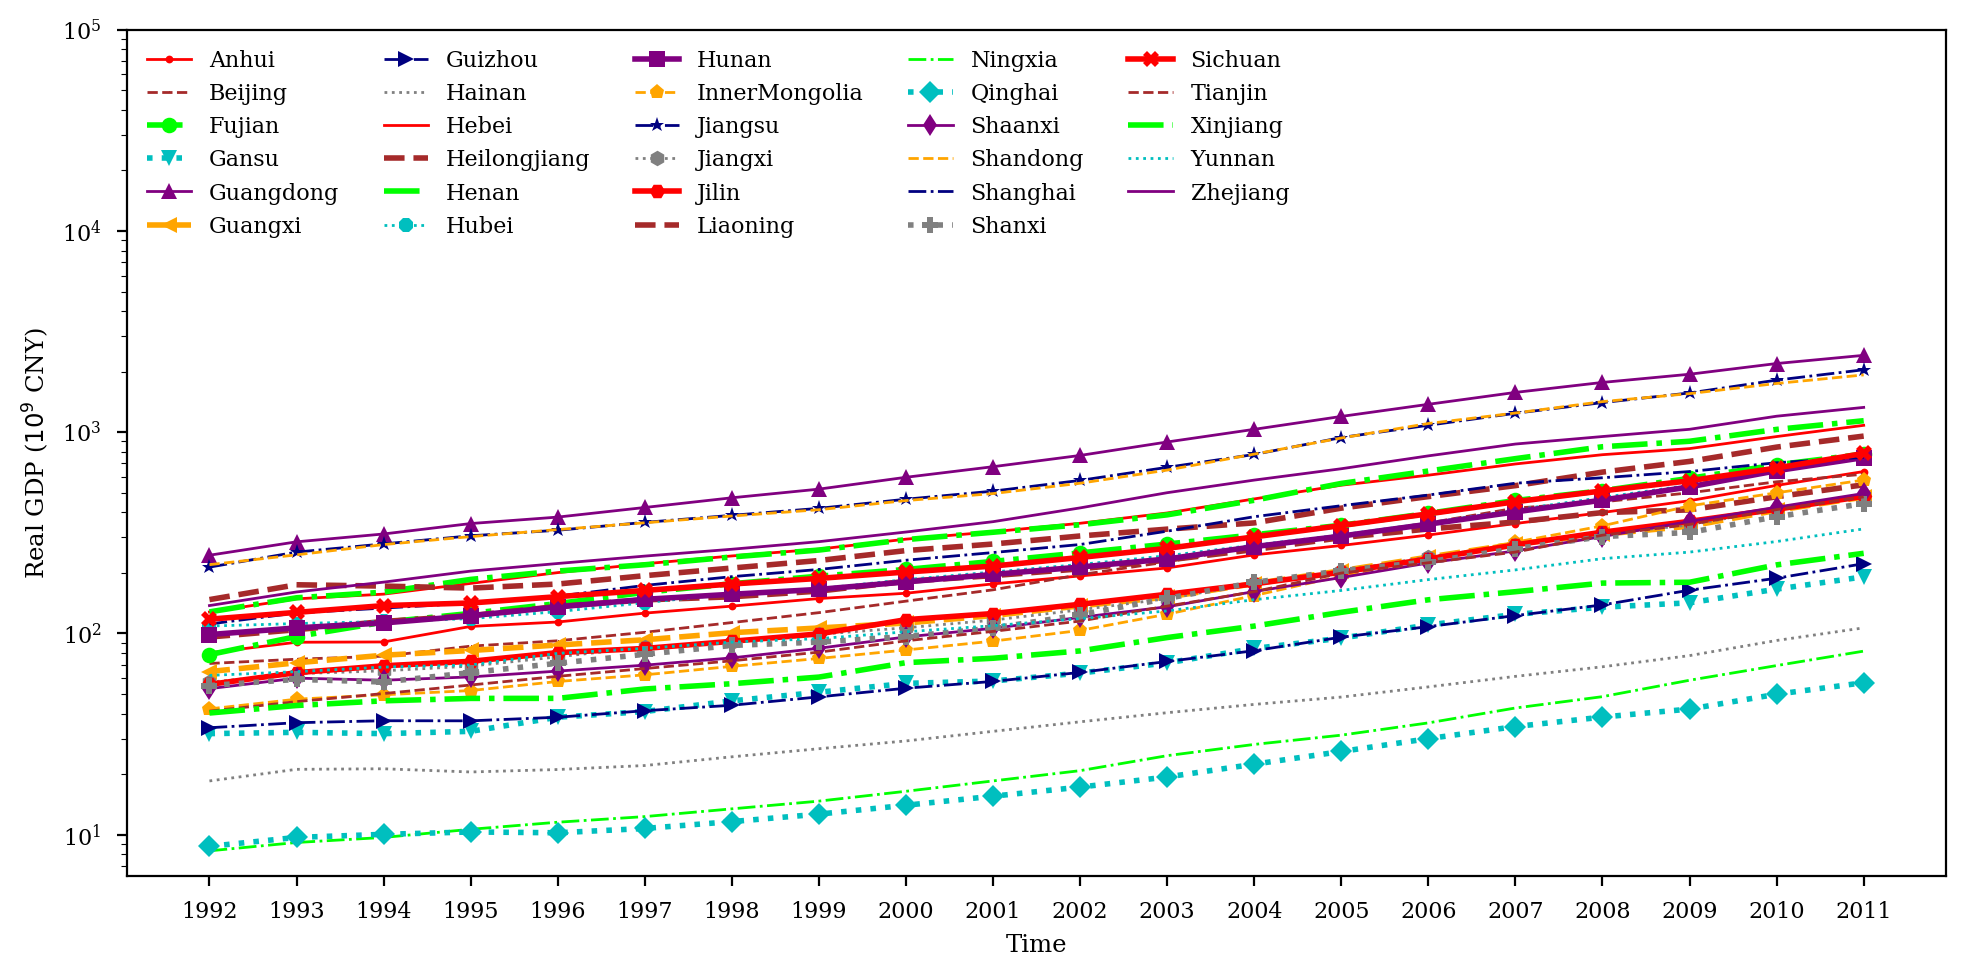

In [35]:
temp = []
for (p, g), (p, c) in zip(gdp, cpi):
    temp.append([p, g.values, c.values])
    
gdp_real = []
for t in temp:
    p = t[0]
    c = np.cumprod(t[2]/100)/(t[2][0]/100)
    g = t[1] / c
    gdp_real.append((p, g))
    
fig = plt.figure()

ax = fig.add_subplot(111)
for province, g in gdp_real:
    ax.plot(year, g, label=province)
ax.set_xticks(year)
ax.legend(loc='upper left', frameon=False, ncol=5)
ax.set_ylabel(r'Real GDP ($10^9$ CNY)')
ax.set_yscale('log')
ax.set_ybound(upper=1e5)
ax.set_xlabel('Time')

plt.tight_layout()
plt.savefig('plots/gdp_real.pdf')
plt.show()

In [36]:
stationary(gdp_real)

29 out of 29 series is not trend-stationary


***Potential GDP***

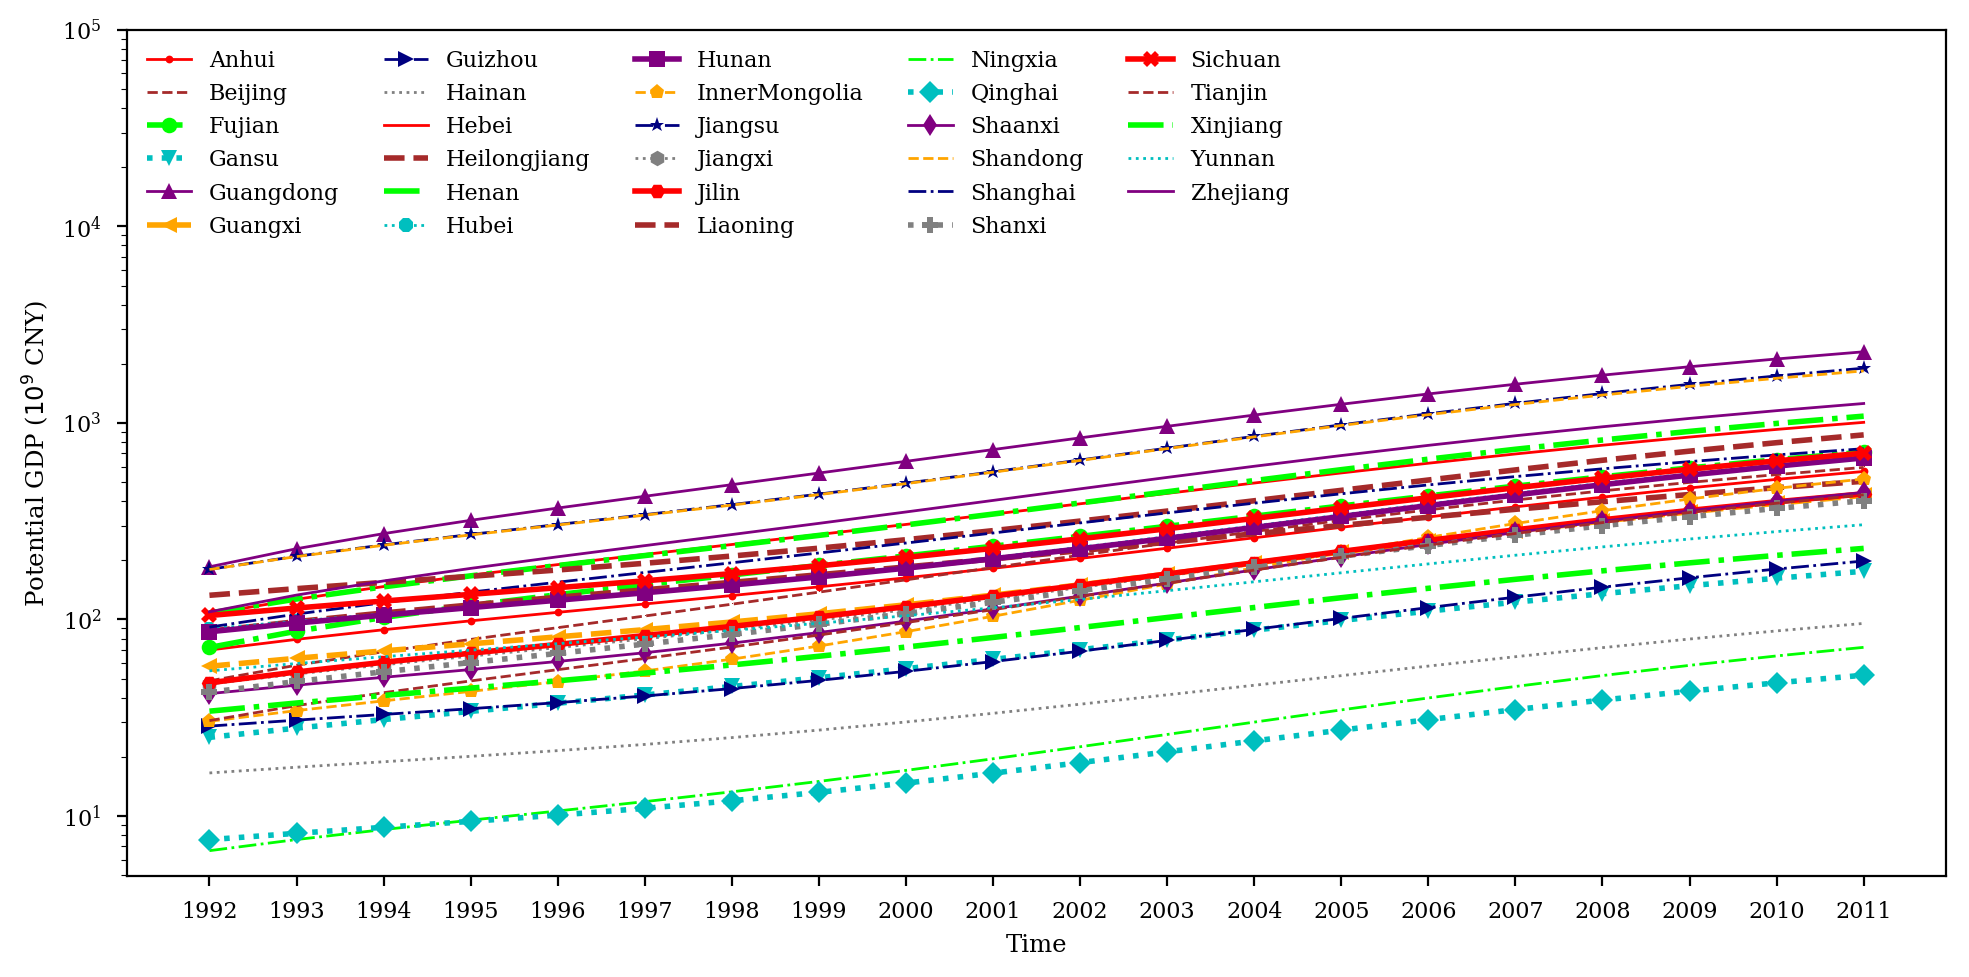

In [37]:
gdp_ptntl = []
for p, g in gdp_real:
    gp = tsa.filters.hpfilter(g, lamb=100)[1]
    gdp_ptntl.append((p, gp))

fig = plt.figure()

ax = fig.add_subplot(111)
for province, g in gdp_ptntl:
    ax.plot(year, g, label=province)
ax.set_xticks(year)
ax.legend(loc='upper left', frameon=False, ncol=5)
ax.set_ylabel(r'Potential GDP ($10^9$ CNY)')
ax.set_yscale('log')
ax.set_ybound(upper=1e5)
ax.set_xlabel('Time')

plt.tight_layout()
plt.savefig('plots/gdp_ptntl.pdf')
plt.show()

***GDP deviation = Real GDP / Potential GDP $\times$ 100 - 100***

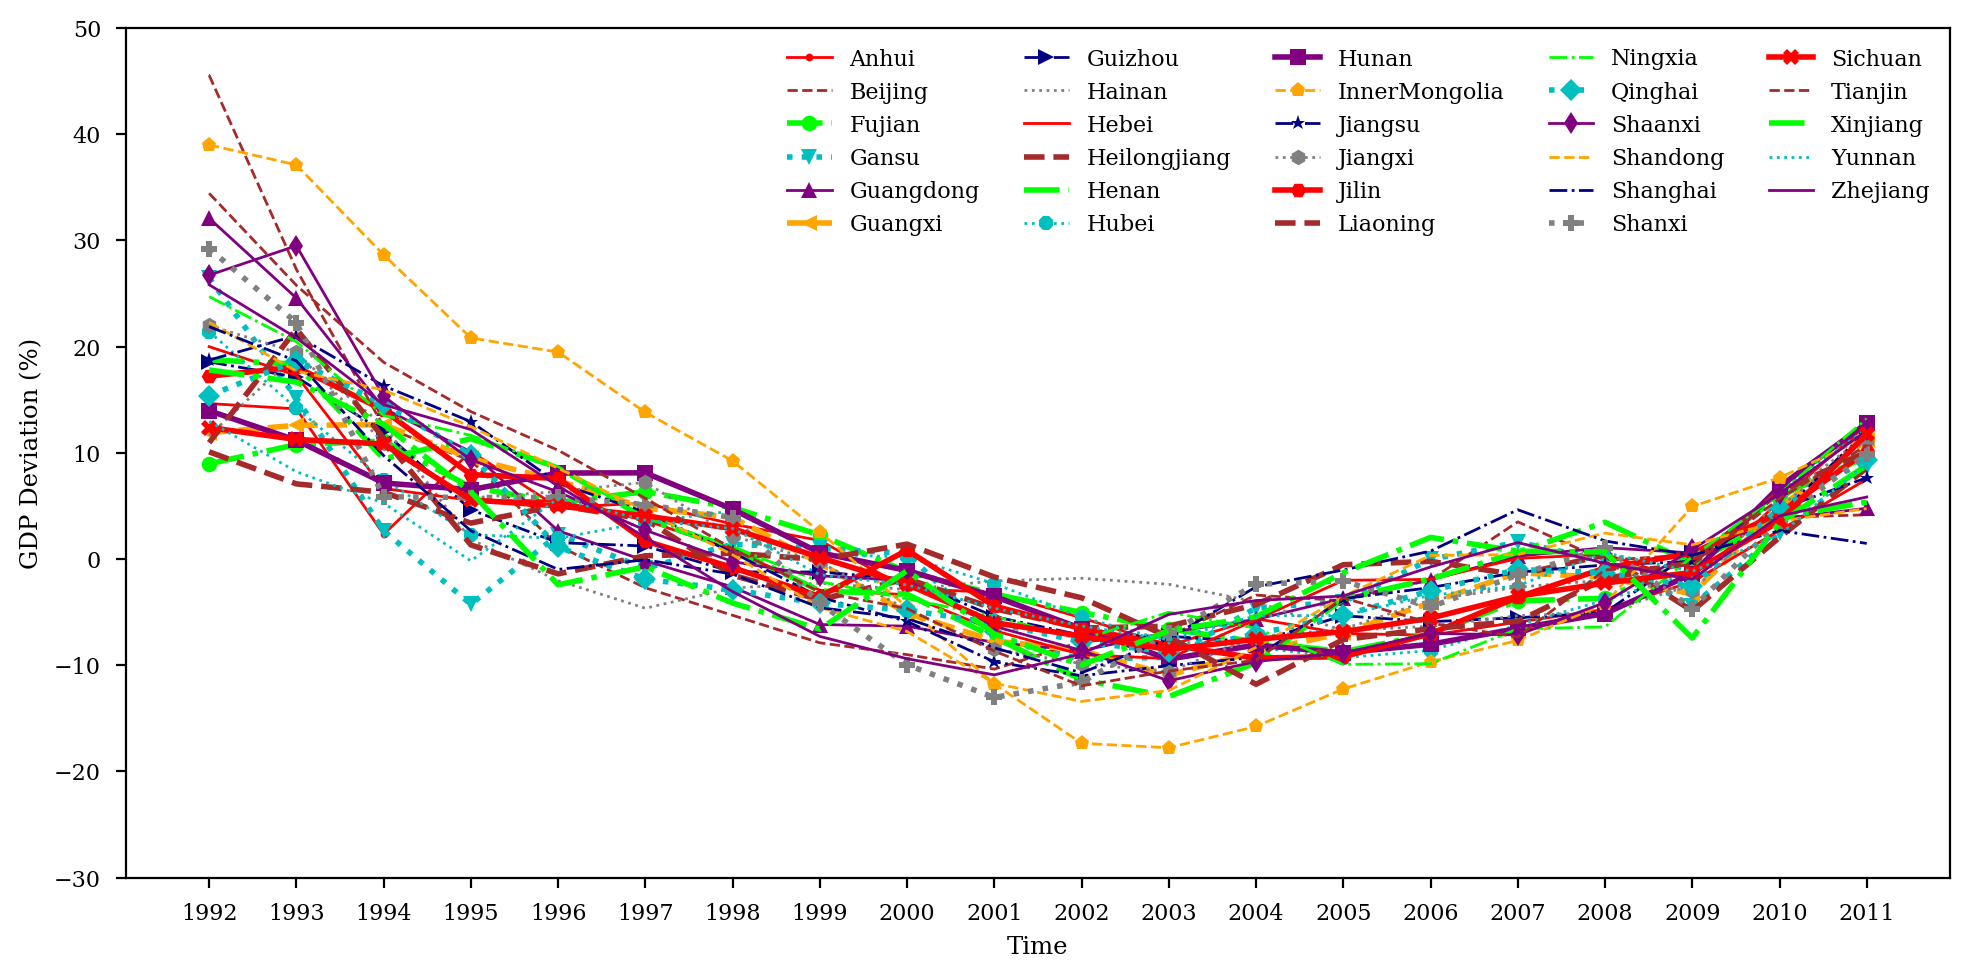

In [44]:
gdp_diff = [(p, g/gp*100-100) for (p,g), (p,gp) in zip(gdp_real, gdp_ptntl)]

fig = plt.figure()

ax = fig.add_subplot(111)
for province, g in gdp_diff:
    ax.plot(year, g, label=province)
ax.set_xticks(year)
ax.legend(loc='upper right', frameon=False, ncol=5)
ax.set_ylabel(r'GDP Deviation (%)')
ax.set_ylim(-30,50)
ax.set_xlabel('Time')

plt.tight_layout()
plt.savefig('plots/gdp_diff.pdf')
plt.show()

In [45]:
stationary(gdp_diff)

29 out of 29 series is not trend-stationary


In [46]:
gdp_diff = pd.DataFrame({pp:p for pp,p in list(gdp_diff)}, index=year)
gdp_diff.to_csv('data/gdp_diff.csv')
gdp_diff.unstack().to_csv('data/gdp_diff_long.csv')

As a conclusion, KPSS rejects stationarity for all series, unfortunately.

However, let's look at the individual cross-sectionally augmented Dicky-Fuller tests. We use `R` to perform this test.

```r
setwd('~/Desktop/Research/InflationDynamicsChina/data')
require(CADFtest)
files <- c('inf.csv', 'unemp.csv', 'gdp_diff.csv', 'gdp_diff_percap.csv')
t <- 1:20
for (f in files) {
  temp_statistic <- c()
  cat(f, '\n')
  df <- data.frame(read.csv(f)[,2:32])
  df[is.na(df)] <- 0
  rm <- rowMeans(df)[1:19]
  for (p in colnames(df)) {
    if (!sum(c(df[1:19,p], diff(df[,p])))) {cat(p, ': all NaN!\n'); next}
    m = CADFtest(I(diff(df[,p])) ~ rm + df[1:19,p], type='none', kernel="Parzen", prewhite=FALSE)
    cat(p, ': ', m[['statistic']], '\n')
    temp_statistic <- c(temp_statistic, m[['statistic']])
  }
  assign(paste0(substr(f,1, nchar(f)-4), '_statistic'), temp_statistic)
  cat('\n')
}

mean(inf_statistic)
mean(unemp_statistic)
mean(gdp_diff_statistic)
mean(gdp_diff_percap_statistic)
```

which gives the following results:

```
> mean(inf_statistic)
[1] -4.105186
> mean(unemp_statistic)
[1] -2.438183
> mean(gdp_diff_statistic)
[1] 0.4633154
> mean(gdp_diff_percap_statistic)
[1] 0.4294486
```

[Link](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.153.3283&rep=rep1&type=pdf) to paper of Pesaran (2007). Check table 2a since we assume "none" which means no intercept or trend.

## Network Visualization

We try to fill NA with 0 here.

In [47]:
rail = list((data.ix[:,6:-1].fillna(0).astype(int)+1).groupby(data.Year)) # + 1 ton to eliminate nan in Moran's I test
province = data.Province.unique()

In [48]:
import pysal
from functions import draw_networkx_edges_with_arrows, network

In [49]:
G_list = []

In [50]:
pop_by_year = np.vstack([p.values for _, p in list(pop)]).T
pop_by_year = [np.outer(pop_by_year[i], pop_by_year[i])**.5 for i in range(20)]

In [51]:
for temp, pop_temp in zip(list(rail), pop_by_year):
    yr = temp[0]
    net = temp[1] / pop_temp
    net.index = province
    net = pd.concat([net.ix[:,i] for i in net.columns], axis=0)
    net = pd.concat([pd.Series(net.index), pd.Series(np.repeat(province, 29)), pd.Series(net.values)], axis=1, ignore_index=True)
    net.columns = ['source', 'target', 'flow']
    mask = net.source == net.target
    net = net[~mask].fillna(0)
    G_list.append(network(plt, net, yr, plot=False, ret=True))

Check out [this webpage](http://allenfrostline.com/2017/11/29/network-visualization/) for the animated visualization.

The upper right regions are highly productive in coal and thus are mainly "exporters", which is validated in the plots. As for Shandong (top left, a big "importer"), I don't understand it yet. But I'm not sure whether it's important in this research. Just plotted them out so that we can intuitively understand the trade flow matrices.

## Moran's I

In [52]:
import pysal

In [53]:
inf = (data.CPI-100).groupby(data.Province)
inf = {p: i.fillna(0).values for p, i in inf}
inf_by_year = list(np.array([inf[p] for p in province]).T)
inf_by_year = [(y, i) for y, i in zip(year, inf_by_year)]

In [55]:
I = []
p = []
for i in range(20):
    w = pysal.weights.WSP(nx.adj_matrix(G_list[i])).to_W()
    m = pysal.Moran(inf_by_year[i][1], w, permutations = 999)
    I.append(m.I)
    p.append(m.p_sim)
    W = w.weights
    for node in W:
        W[node] = W[node][:node] + [0] + W[node][node:]
    W = pd.DataFrame(W)
    W.to_csv('./data/W{}.csv'.format(1992+i))
    
df = pd.DataFrame({'I':I, 'p-value':p, 'rej 5%':np.array(p)<=.05}, index=year)
print(df.mean())
df

I          0.039907
p-value    0.151000
rej 5%     0.200000
dtype: float64


,I,p-value,rej 5%
1992,-0.123372,0.121,False
1993,0.101003,0.057,False
1994,-0.001198,0.316,False
1995,0.011812,0.230,False
1996,0.067595,0.079,False
1997,0.091486,0.046,True
1998,-0.107517,0.171,False
1999,-0.041031,0.485,False
2000,0.026244,0.189,False
2001,0.269409,0.001,True


In [57]:
W.shape

(29, 29)

## To-Do

- Check out [this documentary](http://pysal.readthedocs.io/en/latest/users/tutorials/autocorrelation.html#gamma-index-of-spatial-autocorrelation) of package `PySAL` for spatial autocorrelation tests.